This scripts calculate semantic and temporal scores for the whle FR1 dataset.
It should work for catfr too (although a category score may be more relevant than the semantic score used in this script)

In [1]:
%matplotlib inline
import cmlreaders as cml
%cd '/home1/noaherz/pybeh_pd'
import pybeh_pd as pb
import numpy as np
import seaborn as sns
import pandas as pd
from false_memory_functions import *

/home1/noaherz/pybeh_pd


/home1/noaherz/.conda/envs/cml3/lib/python3.7/site-packages/ptsa/data/timeseries.py:487: FutureWarning: xarray subclass TimeSeriesX should explicitly define __slots__
  class TimeSeriesX(TimeSeries):
/home1/noaherz/.conda/envs/cml3/lib/python3.7/site-packages/openpyxl/worksheet/_reader.py:300: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


## choose experiment

In [2]:
cml.CMLReader.load_events?
# conda install CMLReader (to get the newest version, look at pennmem github)

Signature: cml.CMLReader.load_events(subjects: Union[str, List[str], NoneType] = None, experiments: Union[str, List[str], NoneType] = None, data_type: Union[str, NoneType] = 'events', rootdir: Union[str, NoneType] = None) -> pandas.core.frame.DataFrame
Docstring:
Load events from multiple sessions.

Parameters
----------
subjects
    Subject or list of subjects.
experiments
    Experiment or list of experiments to include.
data_type
    data_type to pass to the CMLReader.load method,
    like "task_events" or "all_events.
    (see :attr:`readers` for available options)
rootdir
    Path to root data directory.
File:      ~/.conda/envs/cml3/lib/python3.7/site-packages/cmlreaders/cmlreader.py
Type:      method


In [7]:
# all_fr1_events = cml.CMLReader.load_events(experiments=["FR1"])
all_fr1_events = cml.CMLReader.load_events(experiments=["catFR1"],data_type='task_events')

In [8]:
events = all_fr1_events.query('type == ["WORD", "REC_WORD"]')
events.rename(columns={'item_name': 'item'}, inplace=True)
events = events[events['list'] > 0]
word_evs = events.query('type == "WORD"')
rec_evs = events.query('type == "REC_WORD"')

#removing subjects who were presented with the same word multiple times (probably repeated data)
n_word_pres = word_evs.groupby(['subject', 'session', 'list', 'item_num']).size().to_frame(name='n').reset_index()
bad_lists = n_word_pres.query('n > 2')
bad_lists[['subject', 'session', 'list']].drop_duplicates()
bad_subs = bad_lists.subject.unique().tolist()
bad_subs = bad_subs + ["R1171M", "R1093J", "R1329T", "R1341T", "R1015J"] #"R1015J" had no recalls, other subjects unsure...
events.query('subject not in @bad_subs', inplace=True)

/home1/noaherz/.conda/envs/cml3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [9]:
events.head(5)

,category,category_num,eegfile,eegoffset,exp_version,experiment,intrusion,is_stim,item,item_num,...,recog_rt,recognized,rectime,rejected,serialpos,session,stim_list,stim_params,subject,type
23,Furniture,11,R1004D_11Nov14_1100,1763275,1.02,catFR1,-999,0,DESK,139,...,NaN,NaN,-999,NaN,1,0,0,[],R1004D,WORD
24,Furniture,11,R1004D_11Nov14_1100,1767193,1.02,catFR1,-999,0,TABLE,138,...,NaN,NaN,-999,NaN,2,0,0,[],R1004D,WORD
25,Vegetables,21,R1004D_11Nov14_1100,1771009,1.02,catFR1,-999,0,CARROT,254,...,NaN,NaN,-999,NaN,3,0,0,[],R1004D,WORD
26,Vegetables,21,R1004D_11Nov14_1100,1775088,1.02,catFR1,-999,0,CUCUMBER,259,...,NaN,NaN,-999,NaN,4,0,0,[],R1004D,WORD
27,Birds,2,R1004D_11Nov14_1100,1779117,1.02,catFR1,-999,0,HAWK,36,...,NaN,NaN,-999,NaN,5,0,0,[],R1004D,WORD


##  temporal clustering

In [10]:
pb_crp = events.groupby('subject').apply(pb.pd_crp, 
                                itemno_column='item_num').reset_index()

I can add one more column to the data frame (e.g. BDI) 
and then add 'hue' to the above plot to seperate the results 
for the low and high depression groups

In [11]:
# load
import pickle
with open('/home1/noaherz/Mental_health5/results/df_master','rb') as pickle_file:
    df_master=pickle.load(pickle_file)
df_master

,BAI,BDI,ELIs,IQ,IQ_type,PLIs,TBI_notes,age_at_implant,age_of_seizure_onset,all recalls,...,gender,implant_date,lists,prior_neurosurgical_procedures,reimplant_date,session,site,subject,total ints,years_of_education
0,8.0,2.0,21.0,72.0,FSIQ4,25.0,NaN,48.105026,20.0,108.0,...,Female,2014-10-08,22.0,NaN,NaT,0.0,University of Pennsylvania,R1001P,46.0,13.0
1,8.0,2.0,19.0,72.0,FSIQ4,17.0,NaN,48.105026,20.0,99.0,...,Female,2014-10-08,23.0,NaN,NaT,1.0,University of Pennsylvania,R1001P,36.0,13.0
2,9.0,0.0,3.0,86.0,FSIQ4,8.0,NaN,49.383743,34.0,128.0,...,Female,2014-11-12,25.0,NaN,NaT,0.0,University of Pennsylvania,R1002P,11.0,16.0
3,9.0,0.0,2.0,86.0,FSIQ4,3.0,NaN,49.383743,34.0,125.0,...,Female,2014-11-12,25.0,NaN,NaT,1.0,University of Pennsylvania,R1002P,5.0,16.0
4,NaN,NaN,30.0,102.0,FSIQ4,26.0,motor vehicle accident due to loss of consciou...,39.390382,37.0,142.0,...,Female,2014-11-13,22.0,NaN,NaT,0.0,University of Pennsylvania,R1003P,56.0,13.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1102,NaN,NaN,6.0,89.0,FSIQ4,1.0,NaN,41.243717,34.0,31.0,...,Female,2021-06-28,9.0,NaN,NaT,0.0,UT Southwestern,R1565T,7.0,18.0
1103,NaN,NaN,16.0,89.0,FSIQ4,18.0,NaN,22.573929,19.0,102.0,...,Female,2021-07-05,25.0,NaN,NaT,0.0,UT Southwestern,R1569T,34.0,NaN
1104,NaN,NaN,11.0,87.0,FSIQ4,18.0,NaN,31.283325,17.0,106.0,...,Male,2021-07-19,24.0,NaN,NaT,0.0,UT Southwestern,R1571T,29.0,NaN
1105,6.0,10.0,4.0,84.0,FSIQ4,4.0,NaN,35.820037,23.0,23.0,...,Female,2021-07-20,5.0,NaN,NaT,0.0,UT Southwestern,R1572T,8.0,NaN


In [12]:
# pd.concat([df_master, pb_crp], join="inner", ignore_index=True)
combined_df=pd.merge(df_master[['BAI','BDI','subject']], pb_crp, on=['subject'], how='left')
combined_df=combined_df.dropna(subset=['BAI', 'BDI'])
combined_df

,BAI,BDI,subject,level_1,prob,lag
0,8.0,2.0,R1001P,NaN,NaN,NaN
1,8.0,2.0,R1001P,NaN,NaN,NaN
2,9.0,0.0,R1002P,NaN,NaN,NaN
3,9.0,0.0,R1002P,NaN,NaN,NaN
17,7.0,7.0,R1006P,NaN,NaN,NaN
...,...,...,...,...,...,...
9338,2.0,7.0,R1542J,2.0,0.020833,2.0
9339,2.0,7.0,R1542J,3.0,0.104651,3.0
9340,2.0,7.0,R1542J,4.0,0.128205,4.0
9341,2.0,7.0,R1542J,5.0,0.087500,5.0


#### Split BDI/BAI scores to high/low

In [13]:
median_BAI=np.median(combined_df['BAI'])
median_BDI=np.median(combined_df['BDI'])
combined_df['high_anxiety']=combined_df['BAI']>median_BAI
combined_df['high_depression']=combined_df['BDI']>median_BDI
combined_df

,BAI,BDI,subject,level_1,prob,lag,high_anxiety,high_depression
0,8.0,2.0,R1001P,NaN,NaN,NaN,False,False
1,8.0,2.0,R1001P,NaN,NaN,NaN,False,False
2,9.0,0.0,R1002P,NaN,NaN,NaN,True,False
3,9.0,0.0,R1002P,NaN,NaN,NaN,True,False
17,7.0,7.0,R1006P,NaN,NaN,NaN,False,False
...,...,...,...,...,...,...,...,...
9338,2.0,7.0,R1542J,2.0,0.020833,2.0,False,False
9339,2.0,7.0,R1542J,3.0,0.104651,3.0,False,False
9340,2.0,7.0,R1542J,4.0,0.128205,4.0,False,False
9341,2.0,7.0,R1542J,5.0,0.087500,5.0,False,False


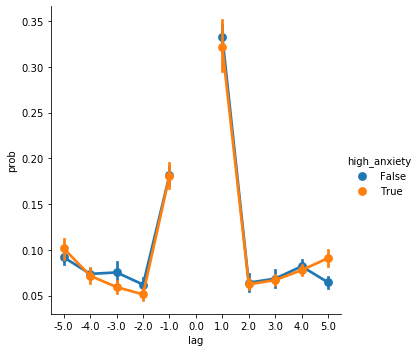

In [14]:
g = sns.catplot(x='lag', y='prob', kind='point', hue = 'high_anxiety',
                  data=combined_df.query('lag <= 5 and lag >= -5')
           )

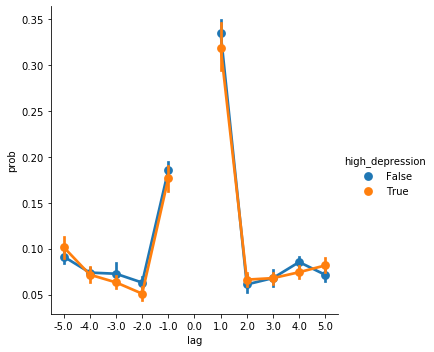

In [15]:
g = sns.catplot(x='lag', y='prob', kind='point', hue = 'high_depression',
                  data=combined_df.query('lag <= 5 and lag >= -5')
           )

calculate temporal factor

In [16]:
pb_temp_fact = events.groupby(['subject', 'session']).apply(pb.pd_temp_fact,
                                                   itemno_column='item_num', 
                                                   list_index=['subject', 'session', 'list'], 
                                                   pres_type="WORD", rec_type="REC_WORD", type_column='type'#, ret_counts=False,
                                                   ).to_frame(name='temp_fact').reset_index()

pb_temp_fact

,subject,session,temp_fact
0,R1004D,0,0.677778
1,R1013E,0,0.614322
2,R1016M,0,0.533312
3,R1016M,1,0.652648
4,R1021D,0,0.630544
...,...,...,...
529,R1626S,3,0.681134
530,R1626S,4,0.579446
531,R1626S,6,0.573677
532,R1627T,0,0.458139


#### combine temporal_factor with BAI/BDI scores

In [17]:
combined_temp_df=pd.merge(df_master[['BAI','BDI','subject','session','gender','IQ','age_of_seizure_onset','age_at_implant','binary_prior_neuro']], pb_temp_fact, on=['subject','session'], how='right')
combined_temp_df = combined_temp_df.dropna(subset=['BAI','BDI','temp_fact'])
# combined_temp_df = combined_temp_df[combined_temp_df['session']==0] # reduce multiple rows for seperate sessions
combined_temp_df
# combined_temp_df.drop(columns='session')

,BAI,BDI,subject,session,gender,IQ,age_of_seizure_onset,age_at_implant,binary_prior_neuro,temp_fact
1,2.0,12.0,R1013E,0.0,Female,98.0,12.0,36.581290,0.0,0.614322
5,2.0,12.0,R1024E,0.0,Female,98.0,12.0,36.759254,0.0,0.616528
12,3.0,6.0,R1032D,0.0,Female,99.0,1.0,19.800658,0.0,0.710290
13,3.0,6.0,R1032D,0.0,Female,99.0,1.0,19.800658,0.0,0.710290
14,3.0,6.0,R1032D,1.0,Female,99.0,1.0,19.800658,0.0,0.654815
...,...,...,...,...,...,...,...,...,...,...
685,24.0,17.0,R1536J,3.0,Female,102.0,13.0,30.593487,0.0,0.649948
693,2.0,7.0,R1542J,0.0,Male,114.0,22.0,29.281915,0.0,0.637768
694,2.0,7.0,R1542J,0.0,Male,114.0,22.0,29.281915,0.0,0.637768
695,2.0,7.0,R1542J,1.0,Male,114.0,22.0,29.281915,0.0,0.663177


## linear mixed effect, looking at the contribution of depression/anxiety to temporal clustering

In [18]:
vc = {'session': '0 + C(session)'} #the vc formula always varies within the groups parameter, so it will vary within subject 
import statsmodels.api as sm

## Total number of intrusions:
model = sm.MixedLM.from_formula('temp_fact ~ 1',  vc_formula=vc, groups='subject', data=combined_temp_df) 
result=model.fit(reml=False, method='nm')
llf_empty =result.llf #log likelihood
print(result.summary())


# demographis variables + depression - main effect ()
# binary_prior_neuro is 'True' when prior neuro procedure was NOT present, 'False' when any king of procedure WAS present 
model = sm.MixedLM.from_formula('temp_fact ~ BDI + BAI',vc_formula=vc, groups='subject', data=combined_temp_df) 
result=model.fit(reml=False, method='nm')
llf_Beck =result.llf #log likelihood
print(result.summary())

# Likelihood ratio tests for depression
print('Main effect of depression and anxiety on temp_fact:')
lr, p = lrtest(llf_empty, llf_Beck, df = 2) # Degrees of freedom = number of regressors (i.e. columns in summary table) added when including the effect of interest, for categorical variable with two groups this is df = 1
print('LR test, p value: {:.4f}, {:.30f}'.format(lr, p))



/home1/noaherz/.conda/envs/cml3/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2149: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: temp_fact
No. Observations: 252     Method:             ML       
No. Groups:       74      Scale:              0.0000   
Min. group size:  1       Log-Likelihood:     1301.0265
Max. group size:  8       Converged:          Yes      
Mean group size:  3.4                                  
-------------------------------------------------------
            Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept   0.577      0.006 93.332 0.000  0.565  0.589
session Var 0.006 543515.965                           

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: temp_fact
No. Observations: 252     Method:             ML       
No. Groups:       74      Scale:              0.0000   
Min. group size:  1       Log-Likelihood:     1302.1331
Max. group size:  8       Converged:          Yes      
Mean grou

/home1/noaherz/.conda/envs/cml3/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2149: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/noaherz/.conda/envs/cml3/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2620: RuntimeWarning: invalid value encountered in sqrt
  sdf[0:self.k_fe, 1] = np.sqrt(np.diag(self.cov_params()[0:self.k_fe]))
/home1/noaherz/.conda/envs/cml3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home1/noaherz/.conda/envs/cml3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home1/noaherz/.conda/envs/cml3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1827: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= 

#### Add demographic variables to the model

In [19]:
demog_df = combined_temp_df.dropna(subset=['gender','binary_prior_neuro', 'age_at_implant','age_of_seizure_onset', 'IQ'])
demog_df.head(5)


,BAI,BDI,subject,session,gender,IQ,age_of_seizure_onset,age_at_implant,binary_prior_neuro,temp_fact
1,2.0,12.0,R1013E,0.0,Female,98.0,12.0,36.581290,0.0,0.614322
5,2.0,12.0,R1024E,0.0,Female,98.0,12.0,36.759254,0.0,0.616528
12,3.0,6.0,R1032D,0.0,Female,99.0,1.0,19.800658,0.0,0.710290
13,3.0,6.0,R1032D,0.0,Female,99.0,1.0,19.800658,0.0,0.710290
14,3.0,6.0,R1032D,1.0,Female,99.0,1.0,19.800658,0.0,0.654815


In [20]:
# vc = {'session': '0 + C(session)'} #the vc formula always varies within the groups parameter, so it will vary within subject 
import statsmodels.api as sm

## Total number of intrusions:
model = sm.MixedLM.from_formula('temp_fact ~ 1',  vc_formula=vc, groups='subject', data=demog_df) 
result=model.fit(reml=False, method='nm')
llf_empty =result.llf #log likelihood
print(result.summary())

# demographis variables - main effect
# binary_prior_neuro is 'True' when prior neuro procedure was NOT present, 'False' when any kind of procedure WAS present 
model = sm.MixedLM.from_formula('temp_fact ~ C(gender)+C(binary_prior_neuro) + age_at_implant + age_of_seizure_onset + IQ', vc_formula=vc, groups='subject', data=demog_df) 
result=model.fit(reml=False, method='nm')
llf_demog =result.llf #log likelihood
print(result.summary())

# Likelihood ratio tests for main effects
print('Main effect of demographics on temp_fact')
lr, p = lrtest(llf_empty, llf_demog, df = 5) # Degrees of freedom = number of regressors (i.e. columns in summary table) added when including the effect of interest, for categorical variable with two groups this is df = 1
print('LR test, p value: {:.4f}, {:.30f}'.format(lr, p))

# demographis variables + depression - main effect ()
# binary_prior_neuro is 'True' when prior neuro procedure was NOT present, 'False' when any king of procedure WAS present 
model = sm.MixedLM.from_formula('temp_fact ~C(gender)+C(binary_prior_neuro) + age_at_implant + age_of_seizure_onset + IQ + BDI + BAI', vc_formula=vc, groups='subject', data=demog_df) 
result=model.fit(reml=False, method='nm')
llf_demog_Beck =result.llf #log likelihood
print(result.summary())

# Likelihood ratio tests for depression
print('Main effect of depression and anxiety on temp_fact, beyond other demographic variables:')
lr, p = lrtest(llf_demog, llf_demog_Beck, df = 2) # Degrees of freedom = number of regressors (i.e. columns in summary table) added when including the effect of interest, for categorical variable with two groups this is df = 1
print('LR test, p value: {:.4f}, {:.30f}'.format(lr, p))



/home1/noaherz/.conda/envs/cml3/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2149: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: temp_fact
No. Observations: 218     Method:             ML       
No. Groups:       65      Scale:              0.0000   
Min. group size:  1       Log-Likelihood:     1210.0592
Max. group size:  8       Converged:          Yes      
Mean group size:  3.4                                  
-------------------------------------------------------
            Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept   0.576      0.007 81.425 0.000  0.563  0.590
session Var 0.006 624258.477                           



/home1/noaherz/.conda/envs/cml3/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2149: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                  Mixed Linear Model Regression Results
Model:                   MixedLM       Dependent Variable:       temp_fact
No. Observations:        218           Method:                   ML       
No. Groups:              65            Scale:                    0.0000   
Min. group size:         1             Log-Likelihood:           1220.4299
Max. group size:         8             Converged:                Yes      
Mean group size:         3.4                                              
--------------------------------------------------------------------------
                             Coef.    Std.Err.    z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------
Intercept                     0.596       0.060  9.872 0.000  0.477  0.714
C(gender)[T.Male]             0.001       0.014  0.081 0.935 -0.027  0.029
C(binary_prior_neuro)[T.1.0] -0.037       0.018 -2.033 0.042 -0.073 -0.001
age_at_implant               -0.001       0.

/home1/noaherz/.conda/envs/cml3/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2149: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/noaherz/.conda/envs/cml3/lib/python3.7/site-packages/statsmodels/base/model.py:1354: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))


## Semantic clustering

In [21]:
# replace item nums so they are consistent across subjects
item_col = 'item'
item_num_col = 'item_num'
item_num_df = events.query('type == "WORD"').drop_duplicates(subset=item_col, ignore_index=True
                                    )[item_col].reset_index().rename(columns={'index': item_num_col})
events_new = events.merge(item_num_df, on=item_col, suffixes=('', '_new'), 
                          how='left', sort=False)#.sort_values('mstime')
events_new.fillna({'item_num_new': -999}, inplace=True)

In [22]:
# import gensim.downloader
# word2vec_vectors = gensim.downloader.load('word2vec-google-news-300')
import gensim.models as models
word2vec_vectors = models.KeyedVectors.load_word2vec_format(
    '/home1/noaherz/word2vec/GoogleNews-vectors-negative300.bin.gz', binary=True)

In [23]:
def word_similarity(df, col1, col2, keyed_vector=None):
    try:
        return keyed_vector.similarity(df[col1].lower(), df[col2].lower())
    except:
        return np.nan

In [24]:
# get all pairs of items
items = item_num_df.item.values
sem_sim_df = pd.MultiIndex.from_product([items, items], names=['item_1', 'item_2']).to_frame(index=False)

In [25]:
sem_sim_df

,item_1,item_2
0,DESK,DESK
1,DESK,TABLE
2,DESK,CARROT
3,DESK,CUCUMBER
4,DESK,HAWK
...,...,...
364811,DIENTE,TERCIOPELO
364812,DIENTE,MEZCLILLA
364813,DIENTE,SEDA
364814,DIENTE,CHURRO


In [26]:
# compute similarity of all pairs
sem_sim_df['similarity'] = sem_sim_df.apply(word_similarity, 
               axis=1, col1='item_1', 
               col2='item_2', 
               keyed_vector=word2vec_vectors)

In [27]:
sem_sim_df

,item_1,item_2,similarity
0,DESK,DESK,1.000000
1,DESK,TABLE,0.404567
2,DESK,CARROT,0.041965
3,DESK,CUCUMBER,0.029637
4,DESK,HAWK,0.053537
...,...,...,...
364811,DIENTE,TERCIOPELO,NaN
364812,DIENTE,MEZCLILLA,NaN
364813,DIENTE,SEDA,NaN
364814,DIENTE,CHURRO,NaN


In [28]:
sem_sim_num_df = sem_sim_df.merge(
    item_num_df, left_on='item_1', right_on='item').merge(
    item_num_df, left_on='item_2', right_on='item', suffixes=('_1', '_2')).drop(columns=['item_1', 'item_2'])

In [31]:
sem_sims = pd.pivot_table(sem_sim_num_df, index='item_num_1', columns='item_num_2', values='similarity', dropna=False)

In [30]:
# events_new.dropna(subset=['session'])
# np.isnan(events_new)

TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

The next cell doesn't work when trying to groupby both subjects and session.
I am therefore doing a for loop instead

In [45]:
# pb_sem_crp = events_new.groupby(['subject']).apply(pb.pd_sem_crp, 
                                itemno_column='item_num_new', sem_sims=sem_sims).reset_index()

In [100]:
##use for loop, for subject and session:
pb_sem_crp1=pd.DataFrame([])
for sub in events_new.subject.unique():
    sub_events= events_new[events_new['subject']==sub]
    for session_num in sub_events.session.unique():
        pb_sem_crp_sub=[]
        sess_events=sub_events[sub_events['session']==sess]
#         print('sub:', sub, 'sess: ',session_num)
        if len(sess_events)>0:
            pb_sem_crp_sub=pb.pd_sem_crp(sess_events,itemno_column='item_num_new',sem_sims = sem_sims)
            pb_sem_crp_sub['subject']=sub
            pb_sem_crp_sub['session']=session_num
            pb_sem_crp1 = pb_sem_crp1.append(pb_sem_crp_sub) # concatenate over subjects

/home1/noaherz/.conda/envs/cml3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/home1/noaherz/pybeh_pd/pybeh_pd.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  evs['pos'] = evs.groupby(list_index).cumcount()
/home1/noaherz/pybeh_pd/pybeh_pd.py:252: RuntimeWarning: invalid value encountered in true_divide
  crp[i, :] = actual / poss  # CRP is calculated as number of actual transitions / number of possible ones
/home1/noaherz/pybe

In [102]:
pb_sem_crp1

,prob,sem_bin_mean,sem_bin,subject,session
1,0.500000,0.054120,1,R1004D,0
3,0.333333,0.087476,3,R1004D,0
5,0.000000,NaN,5,R1004D,0
6,0.333333,0.172497,6,R1004D,0
7,0.000000,NaN,7,R1004D,0
...,...,...,...,...,...
5,0.178571,0.133463,5,R1627T,1
6,0.250000,0.160224,6,R1627T,1
7,0.200000,0.192785,7,R1627T,1
8,0.076923,0.234903,8,R1627T,1


#### Combine semantic similarity with BAI/BDI scores

In [105]:
combined_sem_df=pd.merge(df_master[['BAI','BDI','subject','session','gender','IQ','age_of_seizure_onset','age_at_implant','binary_prior_neuro']], pb_sem_crp1, on=['subject','session'], how='right')
combined_sem_df = combined_sem_df.dropna(subset=['BAI','BDI','sem_bin_mean'])
# combined_temp_df = combined_temp_df[combined_temp_df['session']==0] # reduce multiple rows for seperate sessions
combined_sem_df


,BAI,BDI,subject,session,gender,IQ,age_of_seizure_onset,age_at_implant,binary_prior_neuro,prob,sem_bin_mean,sem_bin
7,2.0,12.0,R1013E,0.0,Female,98.0,12.0,36.581290,0.0,0.137931,-0.011993,0
8,2.0,12.0,R1013E,0.0,Female,98.0,12.0,36.581290,0.0,0.225806,0.038079,1
9,2.0,12.0,R1013E,0.0,Female,98.0,12.0,36.581290,0.0,0.076923,0.064622,2
10,2.0,12.0,R1013E,0.0,Female,98.0,12.0,36.581290,0.0,0.153846,0.088999,3
11,2.0,12.0,R1013E,0.0,Female,98.0,12.0,36.581290,0.0,0.230769,0.113845,4
...,...,...,...,...,...,...,...,...,...,...,...,...
6158,2.0,7.0,R1542J,1.0,Male,114.0,22.0,29.281915,0.0,0.085714,0.156791,6
6159,2.0,7.0,R1542J,1.0,Male,114.0,22.0,29.281915,0.0,0.171429,0.192770,7
6160,2.0,7.0,R1542J,1.0,Male,114.0,22.0,29.281915,0.0,0.171429,0.192770,7
6161,2.0,7.0,R1542J,1.0,Male,114.0,22.0,29.281915,0.0,0.230769,0.261186,8


#### Split BDI/BAI scores to high/low

In [106]:
median_BAI=np.median(combined_sem_df['BAI'])
median_BDI=np.median(combined_sem_df['BDI'])
combined_sem_df['high_anxiety']=combined_sem_df['BAI']>median_BAI
combined_sem_df['high_depression']=combined_sem_df['BDI']>median_BDI
combined_sem_df

,BAI,BDI,subject,session,gender,IQ,age_of_seizure_onset,age_at_implant,binary_prior_neuro,prob,sem_bin_mean,sem_bin,high_anxiety,high_depression
7,2.0,12.0,R1013E,0.0,Female,98.0,12.0,36.581290,0.0,0.137931,-0.011993,0,False,True
8,2.0,12.0,R1013E,0.0,Female,98.0,12.0,36.581290,0.0,0.225806,0.038079,1,False,True
9,2.0,12.0,R1013E,0.0,Female,98.0,12.0,36.581290,0.0,0.076923,0.064622,2,False,True
10,2.0,12.0,R1013E,0.0,Female,98.0,12.0,36.581290,0.0,0.153846,0.088999,3,False,True
11,2.0,12.0,R1013E,0.0,Female,98.0,12.0,36.581290,0.0,0.230769,0.113845,4,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6158,2.0,7.0,R1542J,1.0,Male,114.0,22.0,29.281915,0.0,0.085714,0.156791,6,False,False
6159,2.0,7.0,R1542J,1.0,Male,114.0,22.0,29.281915,0.0,0.171429,0.192770,7,False,False
6160,2.0,7.0,R1542J,1.0,Male,114.0,22.0,29.281915,0.0,0.171429,0.192770,7,False,False
6161,2.0,7.0,R1542J,1.0,Male,114.0,22.0,29.281915,0.0,0.230769,0.261186,8,False,False


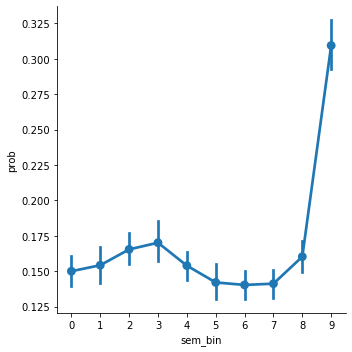

In [107]:
g = sns.catplot(x='sem_bin', y='prob', kind='point', 
                  data=pb_sem_crp
           )

Split groups based on anxiety level (median split)

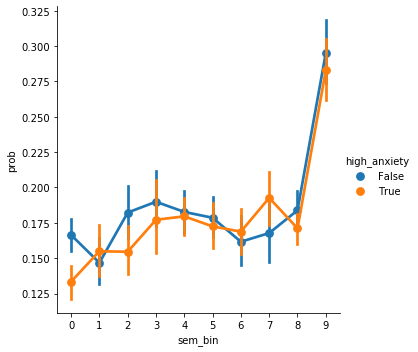

In [110]:
g = sns.catplot(x='sem_bin', y='prob', kind='point', hue='high_anxiety',
                  data=combined_sem_df
           )

Split groups based on depression level (median split)

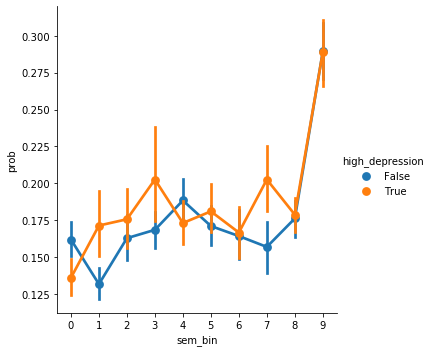

In [111]:
g = sns.catplot(x='sem_bin', y='prob', kind='point', hue='high_depression',
                  data=combined_sem_df
           )

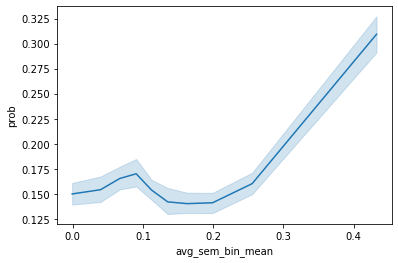

In [112]:
#using average bin value
pb_sem_crp['avg_sem_bin_mean'] = pb_sem_crp.groupby('sem_bin')['sem_bin_mean'].transform('mean')
g = sns.lineplot(x='avg_sem_bin_mean', y='prob', data=pb_sem_crp)

split by group

In [116]:
combined_sem_df
pb_sem_crp1.groupby('sem_bin')['sem_bin_mean'].transform('mean')
combined_sem_df

ValueError: cannot reindex from a duplicate axis

In [35]:
pb_sem_dist_fact = events_new.groupby("subject").apply(pb.pd_dist_fact,
                                                       rec_itemnos=None, 
                                                       itemno_column='item_num_new', 
                                                       list_index=['subject', 'session', 'list'], 
                                                       dist_mat=sem_sims, 
                                                       sim_columns=None, 
                                                       is_similarity=True, 
                                                       dist_columns=None,
                                                       skip_first_n=0,
                                                       pres_type="WORD", rec_type="REC_WORD", type_column='type', ret_counts=False,
                                                       ).to_frame('sem_fact').reset_index()

pb_sem_dist_fact

,subject,sem_fact
0,R1001P,0.423773
1,R1002P,0.463757
2,R1003P,0.484534
3,R1006P,0.519349
4,R1010J,0.521338
...,...,...
269,R1565T,0.464103
270,R1569T,0.472451
271,R1571T,0.638596
272,R1572T,0.525595
